In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
#If using Google Colab
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
z_scores = pd.read_csv('/gdrive/My Drive/project/data_RNA_Seq_mRNA_median_all_sample_Zscores.csv',  sep='\t')
clinical = pd.read_csv('/gdrive/My Drive/project/data_clinical_patient.csv',  sep='\t', error_bad_lines=False)

In [4]:
z_scores

,Hugo_Symbol,Entrez_Gene_Id,TARGET-30-PAAPFA-01,TARGET-30-PACLJN-01,TARGET-30-PACPJG-01,TARGET-30-PACRYY-01,TARGET-30-PACRZM-01,TARGET-30-PACSNL-01,TARGET-30-PACSSR-01,TARGET-30-PACUGP-01,TARGET-30-PACVNB-01,TARGET-30-PACYGY-01,TARGET-30-PACZPX-01,TARGET-30-PADENF-01,TARGET-30-PADFLI-01,TARGET-30-PADHWC-01,TARGET-30-PADIEY-01,TARGET-30-PADIHC-01,TARGET-30-PADINC-01,TARGET-30-PADIRB-01,TARGET-30-PADKFS-01,TARGET-30-PADKFU-01,TARGET-30-PADKGF-01,TARGET-30-PADKNE-01,TARGET-30-PADKRU-01,TARGET-30-PADKVV-01,TARGET-30-PADKXS-01,TARGET-30-PADKYP-01,TARGET-30-PADLDA-01,TARGET-30-PADLDT-01,TARGET-30-PADLES-01,TARGET-30-PADLIC-01,TARGET-30-PADLJN-01,TARGET-30-PADLKJ-01,TARGET-30-PADLNM-01,TARGET-30-PADLPR-01,TARGET-30-PADLPZ-01,TARGET-30-PADLTD-01,TARGET-30-PADMGA-01,TARGET-30-PADMTD-01,...,TARGET-30-PAPZYP-01,TARGET-30-PARABN-01,TARGET-30-PARACM-01,TARGET-30-PARAHE-01,TARGET-30-PARCWT-01,TARGET-30-PARDUJ-01,TARGET-30-PAREGK-01,TARGET-30-PARFBW-01,TARGET-30-PARGDJ-01,TARGET-30-PARGUX-01,TARGET-30-PARHYL-01,TARGET-30-PARIKF-01,TARGET-30-PARIKT-01,TARGET-30-PARIRD-01,TARGET-30-PARJAR-01,TARGET-30-PARJTB-01,TARGET-30-PARMFA-01,TARGET-30-PARMTT-01,TARGET-30-PARNCW-01,TARGET-30-PARNEE-01,TARGET-30-PARRBU-01,TARGET-30-PARSEA-01,TARGET-30-PARSHT-01,TARGET-30-PARUXY-01,TARGET-30-PARVME-01,TARGET-30-PARVRR-01,TARGET-30-PARXLM-01,TARGET-30-PASATK-01,TARGET-30-PASAZJ-01,TARGET-30-PASBEN-01,TARGET-30-PASCKI-01,TARGET-30-PASCLP-01,TARGET-30-PASCUF-01,TARGET-30-PASDZJ-01,TARGET-30-PASFRV-01,TARGET-30-PASGPY-01,TARGET-30-PASJRT-01,TARGET-30-PASJYB-01,TARGET-30-PASKJX-01,TARGET-30-PASLGS-01
0,A1BG,1.0,-1.3428,-0.5008,-0.2098,-1.3428,0.5693,-1.3428,-0.5327,0.8892,-0.0224,1.1756,-1.3428,-0.8466,-0.5236,0.1476,-0.0330,0.1352,-1.3428,0.1514,-1.3428,-0.8258,-1.3428,-0.6396,-0.8690,-1.3428,-1.3428,-1.3428,-0.2094,0.4002,-0.9903,0.8625,0.8990,-1.3428,-1.0961,0.9758,0.4772,-0.6115,-1.3428,-1.3428,...,-1.3428,-0.1723,-1.3428,-1.3428,-1.3428,0.1875,-1.3428,1.0258,-1.3428,-1.3428,-1.3428,-1.3428,0.2415,0.5860,-1.3428,-1.3428,-1.3428,0.3861,-0.1817,-0.0304,-1.3428,0.6186,-0.0580,-0.7070,0.0748,-1.3112,6.0486,0.7991,-1.3428,-1.3428,-1.3428,-1.3428,-1.3428,-1.3428,-1.3428,-1.2901,-0.7847,-1.3428,0.5091,-1.3428
1,A1BG-AS,503538.0,-1.6542,1.2776,-1.6542,0.3708,-0.5274,-0.7503,1.7753,-0.5347,-1.2186,-1.4620,-1.5714,-1.6542,-1.6542,1.5093,1.9770,1.6280,-1.6542,-1.1406,-1.6542,-0.1847,-1.6542,0.4229,-1.6542,-0.9719,-1.6542,-1.3485,-0.7886,0.4305,1.4236,0.9575,1.2606,-0.2656,-1.6542,-0.9956,-0.6724,-1.6542,0.9925,-0.2614,...,-1.6542,-1.6542,-1.6542,-1.2693,-1.6542,-1.6542,0.1059,1.1196,-1.6542,-1.6542,2.1062,-1.2199,-0.2666,-0.7105,-0.5949,-1.6542,-0.1082,0.3788,-1.5647,-1.2956,-1.6542,-1.6542,-1.6542,-0.5011,-0.4916,-1.6542,-1.3391,0.3773,0.7534,-1.6542,-0.9272,-1.6542,0.1667,-1.6542,0.0714,-0.3109,0.7120,-1.6542,-1.6542,-0.2270
2,A1CF,29974.0,-0.9681,-1.1983,-1.1983,-1.1983,-0.5943,-1.1983,1.1816,-1.1983,-1.1983,-1.0784,-1.1983,0.0450,0.2186,-1.1983,-0.3234,-1.1983,-1.1983,0.2892,-1.1983,-1.1983,-1.1983,-1.1983,0.8056,-1.1983,-1.1983,-1.1983,-0.7554,0.5903,-1.1983,-0.7586,-0.1897,-1.1983,-1.1983,-1.1983,0.4602,-1.1983,-0.6340,-1.1983,...,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-0.7602,-1.1983,-1.1983,-1.1983,-1.1983,-0.4374,0.2225,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-0.6038,-1.1983,-1.1983,4.8368,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983,-1.1983
3,A2LD1,87769.0,-1.5144,1.2333,0.3050,-1.5144,0.5219,-1.5144,1.2531,-1.5144,-0.1521,-0.3651,-1.3957,-1.5144,-1.5144,0.5711,-1.4961,-1.5144,0.6038,-1.5144,-1.5144,-1.5144,-0.9633,-0.8677,-0.4123,0.3837,-0.0914,2.1383,1.3250,-0.6856,-1.5144,-1.3656,0.0732,1.1914,-1.5144,-1.2012,-1.0522,-1.5144,0.5399,-1.5144,...,-1.5144,0.4937,-1.5144,-1.5144,-1.5144,-1.5144,0.1458,2.2615,-1.5144,-1.5144,0.8753,-1.5144,1.7732,1.8223,-0.8193,-1.5144,0.7074,-0.9190,-1.5144,-1.5144,-1.3606,-1.2810,-1.5144,-0.2372,-1.5144,-1.5144,-0.0821,-0.7090,-

In [5]:
clinical

,#Patient Identifier,Protocol,ICDO,SNOMED,ICDO Snomed Description,Diagnosis Age (days),Diagnosis Age,Year of Diagnosis,INSS Stage,Tumor Sample Histology,Diagnosis,EFS-CENS,SCENS,EFS Time,STIME,Sex,Ethnicity Category,Race Category,Risk Group,Percent Tumor Purity,First Event,Overall Survival Status,Overall Survival Days,Overall Survival (Months),Year of Last Followup,Percent Necrosis,Percent Tumor Vs. Stroma,Percent Tumor Cells from patient's relapse biopsy,Relapse Percent Necrosis,Relapse Percent Tumor Vs Stroma
0,#Identifier to uniquely specify a patient.,Protocol.,ICDO.,SNOMED,ICDO snomed description.,Age at which a condition or disease was first ...,Age at which a condition or disease was first ...,Year of Diagnosis,Staging according to the International Neurobl...,Tumor Sample Histology,Diagnosis.,Event Free Survival Censored,SCENS.,EFS time.,STIME.,Sex,The text for reporting information about ethni...,The text for reporting information about race.,Risk group.,Percent tumor purity.,First Event,Overall patient survival status.,Overall patient survival days,Overall survival in months since initial diago...,Year of Last Followup,Percent necrosis.,Numeric representation of the ratio of tumor t...,Numeric value to represent the percentage of m...,Numeric value to represent the percentage of c...,Numeric representation of the percent of tumor...
1,#STRING,STRING,STRING,STRING,STRING,NUMBER,NUMBER,NUMBER,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,NUMBER,NUMBER,STRING,STRING,STRING,STRING,NUMBER,STRING
2,#1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,9,1,1,1,1,1,1,1,1
3,PATIENT_ID,PROTOCOL,ICDO,SNOMED,ICDO_SNOMED_DESCRIPTION,AGE_IN_DAYS,AGE,YEAR_OF_DIAGNOSIS,INSS_STAGE,TUMOR_SAMPLE_HISTOLOGY,DIAGNOSIS,EFSCENS,SCENS,EFS_TIME,STIME,SEX,ETHNICITY,RACE,RISK_GROUP,PERCENTAGE_TUMOR_PURITY,FIRST_EVENT,OS_STATUS,OS_DAYS,OS_MONTHS,LAST_FOLLOWUP_YEAR,PERCENTAGE_NECROSIS,PERCENT_TUMOR_VS_STROMA,PERCENT_TUMOR_CELLS_RELAPSE,RELAPSE_PERCENT_NECROSIS,RELAPSE_PERCENT_STROMA
4,TARGET-30-PALPKZ,ANBL00B1,C38.2,NaN,Posterior mediastinum,1157,4,2002,Stage 4,Unfavorable,Neuroblastoma,NaN,NaN,1566.0,NaN,Male,Not Hispanic or Latino,White,High Risk,NaN,Progression,1:DECEASED,2103.0,70.0,2008.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,TARGET-30-PATLUI,"ANBL00B1, ANBL0532, ANBL0032",C74.9,NaN,"Adrenal gland, NOS Suprarenal gland Adrenal, NOS",799,3,2010,Stage 3,Unfavorable,Neuroblastoma,NaN,NaN,1942.0,NaN,Male,Hispanic or Latino,White,High Risk,70,Censored,0:LIVING,1942.0,64.0,2015.0,NaN,NaN,NaN,NaN,NaN
1076,TARGET-30-PAJYVA,"321P2, B003",Unknown,999,Unknown,708,2,1990,Stage 4,Unfavorable,Unknown,1.0,1.0,238.0,303.0,Female,Unknown,Unknown,High Risk,NaN,Event,1:DECEASED,306.0,11.0,1991.0,NaN,NaN,NaN,NaN,NaN
1077,TARGET-30-PAUGWT,ANBL00B1,C76.2,NaN,"Abdomen, NOS Abdominal wall, NOS Intra-abdomin...",190,1,2011,Stage 4s,Favorable,Neuroblastoma,NaN,NaN,172.0,NaN,Male,Not Hispanic or Latino,White,High Risk,70,Death,1:DECEASED,172.0,6.0,2011.0,NaN,NaN,NaN,NaN,NaN
1078,TARGET-30-PAUBSW,"ANBL00B1, ANBL0532, ANBL0032, ADVL0912",C48.0,NaN,Retroperitoneum Periadrenal tissue Perinephric...,1057,3,2011,Stage 4,Unfavorable,Neuroblastoma,NaN,NaN,486.0,NaN,Female,Not Hispanic or Latino,White,High Risk,70,Relapse,1:DECEASED,700.0,24.0,2013.0,NaN,NaN,NaN,NaN,NaN


In [6]:
print('Number of samples/participants:', clinical[4:].shape[0])
print('Number of clinical features:', clinical.shape[1])
print('Number of genes:', z_scores.shape[0])

Number of samples/participants: 1076
Number of clinical features: 30
Number of genes: 23434


In [12]:
#Remove subjects that don't have a survival status value
clinical = clinical[clinical['Overall Survival Status'].notna()]
clinical = clinical.drop(clinical.loc[clinical["Overall Survival Status"]=='none'].index)

In [8]:
#Change the column name to see all the different values of that column and their occurance
clinical["Overall Survival Status"].value_counts()

0:LIVING                            675
1:DECEASED                          397
STRING                                1
9                                     1
OS_STATUS                             1
Overall patient survival status.      1
Name: Overall Survival Status, dtype: int64

In [9]:
#Library to perform over sampling to ensure balanced classes
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import numpy as np

#Get columns wanted in the decision tree
X = clinical.loc(axis=1)['Diagnosis Age (days)', 'INSS Stage', 'ICDO', 'Tumor Sample Histology', 'Sex', 'Ethnicity Category', 'Race Category']
X = X[4:] #First 4 rows arent subject so dont include them
#Encode the columns into numerical values
le = LabelEncoder()
X['INSS Stage'] = le.fit_transform(X['INSS Stage'])
X['ICDO'] = le.fit_transform(X['ICDO'])
X['Tumor Sample Histology'] = le.fit_transform(X['Tumor Sample Histology'])
X['Sex'] = le.fit_transform(X['Sex'])
X['Ethnicity Category'] = le.fit_transform(X['Ethnicity Category'])
X['Race Category'] = le.fit_transform(X['Race Category'])
X = X.to_numpy()

clinical['Overall Survival Status'] = clinical['Overall Survival Status']
y = clinical.loc(axis=1)['Overall Survival Status']
y = y[4:].to_numpy()
y = le.fit_transform(y)

X_over, y_over = oversample.fit_resample(X, y) #Oversampling
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=1) #Split into train and test

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [14]:
#Build the decision tree
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=4)
decision_tree = decision_tree.fit(X_train, y_train)

#Test and evaluate the decision tree
y_pred = decision_tree.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.7037037037037037
Recall: 0.9398148148148148
Precision: 0.6548387096774193


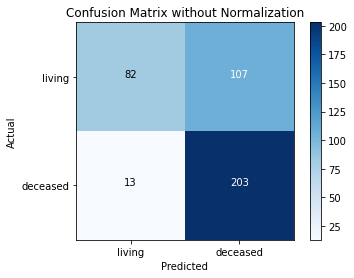

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
#Plot confusion matrix
categorical_test_labels = pd.DataFrame(y_test)
categorical_preds = pd.DataFrame(y_pred)
cf = confusion_matrix(categorical_test_labels, categorical_preds)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(categorical_preds))) # length of classes
class_labels = ['living','deceased']
tick_marks  = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

In [17]:
#One way of visualising the tree
r = export_text(decision_tree, feature_names=('Diagnosis Age (days)', 'INSS Stage', 'ICDO', 'Tumor Sample Histology', 'Sex', 'Ethnicity Category', 'Race Category'))
print(r)

|--- INSS Stage <= 3.50
|   |--- Sex <= 0.50
|   |   |--- Diagnosis Age (days) <= 127.00
|   |   |   |--- INSS Stage <= 2.00
|   |   |   |   |--- class: 0
|   |   |   |--- INSS Stage >  2.00
|   |   |   |   |--- class: 1
|   |   |--- Diagnosis Age (days) >  127.00
|   |   |   |--- Diagnosis Age (days) <= 1349.50
|   |   |   |   |--- class: 0
|   |   |   |--- Diagnosis Age (days) >  1349.50
|   |   |   |   |--- class: 0
|   |--- Sex >  0.50
|   |   |--- Ethnicity Category <= 1.50
|   |   |   |--- class: 0
|   |   |--- Ethnicity Category >  1.50
|   |   |   |--- Race Category <= 4.50
|   |   |   |   |--- class: 1
|   |   |   |--- Race Category >  4.50
|   |   |   |   |--- class: 0
|--- INSS Stage >  3.50
|   |--- Diagnosis Age (days) <= 319.50
|   |   |--- Tumor Sample Histology <= 0.50
|   |   |   |--- Race Category <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- Race Category >  2.50
|   |   |   |   |--- class: 0
|   |   |--- Tumor Sample Histology >  0.50
|   |   |   |--- Diagn

[Text(660.1339285714286, 815.4, 'INSS Stage <= 3.5\ngini = 0.5\nsamples = 945\nvalue = [486, 459]\nclass = Living'),
 Text(323.8392857142857, 634.2, 'Sex <= 0.5\ngini = 0.085\nsamples = 180\nvalue = [172, 8]\nclass = Living'),
 Text(199.28571428571428, 453.0, 'Diagnosis Age (days) <= 127.0\ngini = 0.158\nsamples = 81\nvalue = [74, 7]\nclass = Living'),
 Text(99.64285714285714, 271.80000000000007, 'INSS Stage <= 2.0\ngini = 0.36\nsamples = 17\nvalue = [13, 4]\nclass = Living'),
 Text(49.82142857142857, 90.60000000000002, 'gini = 0.133\nsamples = 14\nvalue = [13, 1]\nclass = Living'),
 Text(149.46428571428572, 90.60000000000002, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = Deceased'),
 Text(298.92857142857144, 271.80000000000007, 'Diagnosis Age (days) <= 1349.5\ngini = 0.089\nsamples = 64\nvalue = [61, 3]\nclass = Living'),
 Text(249.10714285714283, 90.60000000000002, 'gini = 0.035\nsamples = 56\nvalue = [55, 1]\nclass = Living'),
 Text(348.75, 90.60000000000002, 'gini = 0.375\nsamp

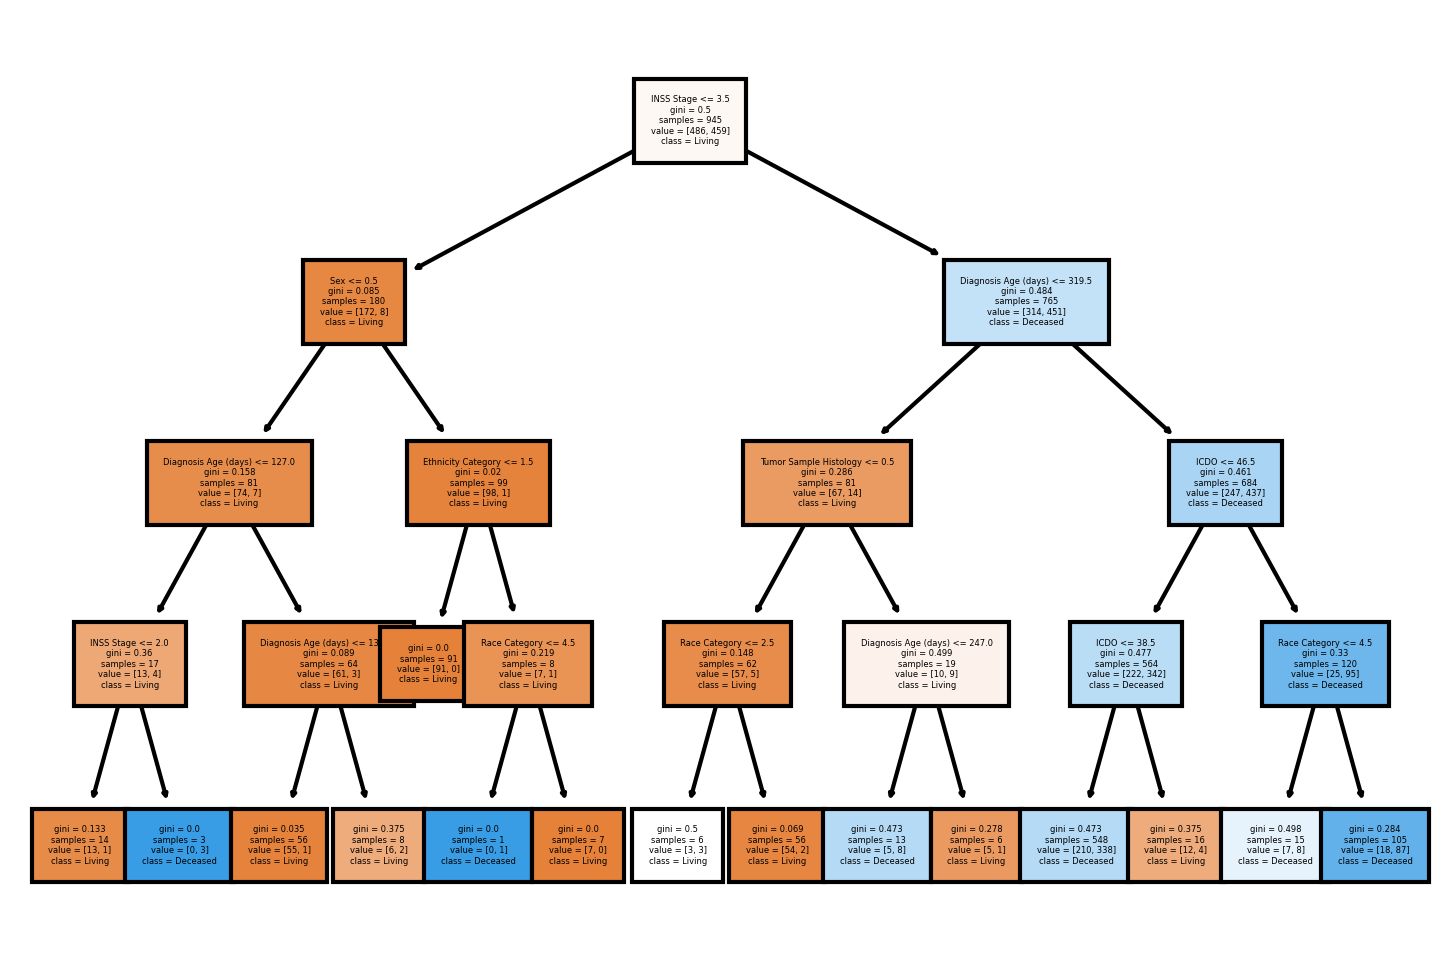

In [23]:
#Another way of visualising the tree
from sklearn import tree
import matplotlib.pyplot as plt

fn = ['Diagnosis Age (days)', 'INSS Stage', 'ICDO', 'Tumor Sample Histology', 'Sex', 'Ethnicity Category', 'Race Category']
cn = ['Living', 'Deceased']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=300)
tree.plot_tree(decision_tree, feature_names = fn, class_names=cn, filled = True, fontsize=2) 